<a href="https://colab.research.google.com/github/harshdeep1211/Amazon-Fine-Food-Reviews/blob/main/Amazonself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import io
 
from mlxtend.classifier import StackingClassifier
 
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
import nltk
from google.colab import files

# **Loading the Data**
The dataset is available in two forms :

1. .csv file
2. SQLite Database

I am loading the dataset using .csv files.

In [48]:
data = pd.read_csv('Reviews.csv',engine = 'python',encoding='utf-8', error_bad_lines=False)
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  4257
Number of features :  10
Features :  ['Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text']


Skipping line 4259: unexpected end of data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [49]:
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
ac=data['Score']
x = ac.map(partition) 
data['Score'] = x
print("Number of data points in our data", data.shape)
data.head()


Number of data points in our data (4257, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# **Exploratory Data Analysis** 

### **Data Cleaning: Deduplication**

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [74]:
duplicate = data[(data['UserId']=="AR5J8UI46CURR") & (data['Score'] !=3)]
duplicate.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [51]:
print("Before Duplicate Removal :" , data.shape)
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("After Duplicate Removal :" , final.shape)


Before Duplicate Removal : (4257, 10)
After Duplicate Removal : (4245, 10)


In [52]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)
final['Score'].value_counts()
final[final.isnull().any(axis=1)]


(4245, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


# **Text Preprocessing: Stemming, stop-word removal and Lemmatization.** 

In the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word

In [53]:

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

snow = SnowballStemmer(language='english')
def nlpr(t, index , column):
   if type(t) is not int:
        string = ""
        
        example1 = BeautifulSoup(t)
        t = example1.get_text()
        # replace every special char with space
        t = re.sub('\W', ' ', t)
        t = re.sub('\d', ' ', t)


        # replace multiple spaces with single space
        t = re.sub('\s+',' ', t)
        # converting all the chars into lower-case.
        t = t.lower()
        
        t = snow.stem(t)

       
        
        for word in t.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        final[column][index] = string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
for index, row in final.iterrows():
    if type(row['Text']) is str:
        nlpr(row['Text'], index, 'Text')
    else:
        print("there is no text description for id:",index)


# **TF_IDF**

In [55]:
tfidf = TfidfVectorizer(lowercase=False,ngram_range=(1,2) )
final_tf_idf=tfidf.fit_transform(final['Text'])


In [56]:
features = tfidf.get_feature_names()
print("some sample features(unique words in the corpus)", features)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['_totally', '_totally unfriendly', 'aa', 'aa sumatra', 'aahhhs', 'aahhhs get', 'aback', 'aback brand', 'abates', 'abates steeping', 'abbi', 'abbott', 'abbott nutrition', 'abdominal', 'abdominal cramping', 'abiding', 'abiding childhood', 'ability', 'ability able', 'ability adjust', 'ability eat', 'ability enjoy', 'ability expiration', 'ability keep', 'ability leave', 'ability obtain', 'ability rate', 'able', 'able actually', 'able add', 'able anything', 'able assemble', 'able biscuit', 'able buy', 'able carry', 'able choose', 'able coffee', 'able communicate', 'able connect', 'able convince', 'able digest', 'able drink', 'able eat', 'able enjoy', 'able even', 'able expand', 'able feed', 'able find', 'able flavors', 'able fully', 'able get', 'able give', 'able go', 'able keep', 'able locate', 'able make', 'able meet', 'able mic', 'able much', 'able munch', 'able order', 'able pour', 'able pry', 'able purchace', 'able purchase', 'able rela

In [57]:
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,10)

In [58]:
top_tfidf

,feature,tfidf
0,victor,0.298459
1,fly,0.273399
2,fly magnet,0.156559
3,refill dp,0.156559
4,com victor,0.156559
5,genocide,0.156559
6,genocide pretty,0.156559
7,fly genocide,0.156559
8,bait refill,0.156559
9,right nearby,0.156559


# **Splitting the Data**

In [59]:
X = final_tf_idf
Y = final['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (2844, 121002) (2844,)
X_test, Y_test (1401, 121002) (1401,)
X_tr, Y_tr (1905, 121002) (1905,)
X_cv, Y_cv (939, 121002) (939,)


# **Evaluating Model Performance using a Random Model**

In [60]:
test_data_len = Y_test.shape[0]
cv_data_len = X_cv.shape[0]

cv_predicted_y = np.zeros((cv_data_len,2))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,2)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(Y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,2))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,2)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test,test_predicted_y, eps=1e-15))
print("y_test shape :" , Y_test.shape , "test_predicted_y shape :" ,test_predicted_y.shape )


Log loss on Cross Validation Data using Random Model 0.8980855919998614
Log loss on Test Data using Random Model 0.8828003989396787
y_test shape : (1401,) test_predicted_y shape : (1401, 2)


# **Training Model using MultiNomial Naive Bayes**

for alpha = 1e-05
Log Loss : 0.327540943404656
for alpha = 0.0001
Log Loss : 0.3258573674956561
for alpha = 0.001
Log Loss : 0.3339919967250474
for alpha = 0.1
Log Loss : 0.3258905865656072
for alpha = 1
Log Loss : 0.35998912402103095
for alpha = 10
Log Loss : 0.3746802890252158
for alpha = 100
Log Loss : 0.3777751482143773
for alpha = 1000
Log Loss : 0.37813150888680086


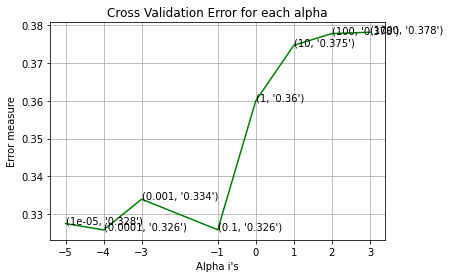

For values of best alpha =  0.0001 The train log loss is: 0.2252310095492212
For values of best alpha =  0.0001 The cross validation log loss is: 0.3258573674956561
For values of best alpha =  0.0001 The test log loss is: 0.36469427436360435


In [61]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_tr, Y_tr)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, Y_tr)
    sig_clf_probs = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_tr, Y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, Y_tr)


predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [62]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_tr, Y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, Y_tr)
sig_clf_probs = sig_clf.predict_proba(X_cv)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(Y_cv, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_cv)- Y_cv))/Y_cv.shape[0])

Log Loss : 0.3258573674956561
Number of missclassified point : 0.13631522896698617


# **Observations**

LogLoss using random Model Implemented was 0.89 whereas LogLoss using Multinomial Naive Bayes is 0.32. That clearly shows Multinomial NB is working way better than a RandomModel.

# **Plotting ROC Curve and Confusion Matrix for MultiNomaial NB**

In [63]:
!pip install scikit-plot


In [64]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import scikitplot.metrics as skplt

def testing(X_tr,Y_tr,X_test,Y_test,optimal_alpha):
    bnb = MultinomialNB(optimal_alpha,fit_prior=True, class_prior=None)
    bnb.fit(X_tr,Y_tr)
    probs = bnb.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    prediction=bnb.predict(X_test)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))
    

AUC Score 0.7999831892961664
macro f1 score for data : 0.6509447662002631
micro f1 scoore for data: 0.7501784439685939
hamming loss for data: 0.24982155603140613
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.35      0.68      0.46       222
           1       0.93      0.76      0.84      1179

    accuracy                           0.75      1401
   macro avg       0.64      0.72      0.65      1401
weighted avg       0.84      0.75      0.78      1401



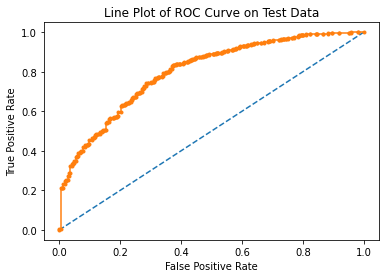

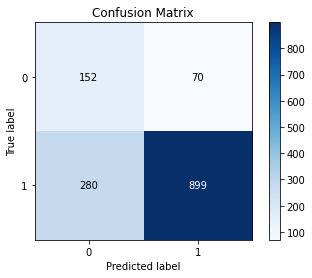

In [65]:
testing(X_tr,Y_tr,X_test,Y_test,optimal_alpha=0.0001)